In [4]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor, DMatrix, cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
def import_data(path='int20h-ds-test-dataset.csv'):
    raw_data = pd.read_csv(path)
    raw_data['event_created_date'] = pd.to_datetime(raw_data['event_created_date'])
    raw_data.set_index('userid', inplace=True)
    return raw_data

raw_data = import_data()

In [6]:
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Gets category for each user
        # We are dropping NaN in categories, because that means that the user had only outofband or NaN in all of their events.
        cat_cols = ['user_state', 'event_platform', 'device_manufacture', 'device_model']
        tmp = X.groupby('userid')[cat_cols] \
            .apply(lambda x: x[x!='outofband'].mode()).reset_index().drop(['level_1'], axis='columns')
        tmp.dropna(subset=['userid'] + cat_cols, inplace=True)

        # OneHot those categories
        ohe = OneHotEncoder(min_frequency=0.07, sparse=False, drop='if_binary')
        tmp = pd.DataFrame(data=ohe.fit_transform(tmp.drop(['userid'], axis='columns')), columns=ohe.get_feature_names_out()).set_index(tmp.userid)

        # Create 'Date of Subscription event' column and drop all users without subscription.
        X['subDate'] = X[X['event_name'] == 'Subscription Premium']['event_created_date']
        X.dropna(subset=['subDate'], inplace=True)

        # Create 'Last action OR Sub cancel' column
        X['endDate'] = X.groupby('userid').last()['event_created_date']
        cancelDate = X[X['event_name'] == 'Subscription Premium Cancel']['event_created_date']
        for idx, val in zip(cancelDate.index, cancelDate.to_numpy()):
            X.loc[idx, 'endDate'] = val
        X.reset_index(inplace=True)

        # Drop all events at the Non Subscription time
        for row in X.itertuples():
            if row.event_created_date > row.endDate or row.event_created_date < row.subDate:
                X.drop(row.Index, inplace=True)

        # Gets count of each event for every user.
        X = X.groupby('userid')['event_name'].apply(lambda x: Counter(x)).reset_index()
        X.fillna(0, inplace=True)

        # Pivot X from long to wide data format
        X = pd.pivot(X, index='userid', columns='level_1', values='event_name')

        # Merge cats and counts for each user
        X = X.merge(tmp, how='inner', left_index=True, right_index=True)

        # Leave only Subs_Pem >= 1, drop subs_prem, subs_renew columns (add analysis why it is useless).
        # Change SubsPremCancel to bool. Yes, it could have value 2, though, not enough data to extract something from that
        X = X[X['Subscription Premium'] != 0].drop(['Subscription Premium', 'Subscription Premium Renew'], axis='columns')
        X['Subscription Premium Cancel'] = X['Subscription Premium Cancel'].astype('bool')

        return X

In [7]:
data = DataTransformer().fit_transform(X=raw_data)

C:\Users\boris\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 706 entries, 0006869712ec9841dc36234bce245203 to fdb9c5f6193e1cc735a2c59e14882b0f
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Account History Transaction Details    706 non-null    float64
 1   Account Setup Profile Skip             706 non-null    float64
 2   Add Payment Method Failed              706 non-null    float64
 3   Add Payment Method Success             706 non-null    float64
 4   Add Vehicle Break                      706 non-null    float64
 5   Add Vehicle Failed                     706 non-null    float64
 6   Add Vehicle Success                    706 non-null    float64
 7   Calculator Used                        706 non-null    float64
 8   Calculator View                        706 non-null    float64
 9   Chat Conversation Opened               706 non-null    float64
 10  Chat Conversation S

##### We will use XGBClassifier as our model.
##### In the exploration process, we have found optimal params for it. Let's check model performs on CV.

In [9]:
X, y = data.drop('Subscription Premium Cancel', axis=1), data['Subscription Premium Cancel']
data_dmatrix = DMatrix(data=X, label=y)

params = {"objective":"reg:logistic",'colsample_bytree': 0.5,'learning_rate': 0.1,
          'max_depth': 5, 'alpha': 1, 'lambda': 0}

xgb_cv = cv(dtrain=data_dmatrix, nfold=5, metrics='auc', as_pandas=True, params=params, num_boost_round=50, early_stopping_rounds=10,)

xgb_cv.iloc[-1]

train-auc-mean    0.966622
train-auc-std     0.002816
test-auc-mean     0.900070
test-auc-std      0.014948
Name: 49, dtype: float64

##### Now let's fit the model and get feature importances.

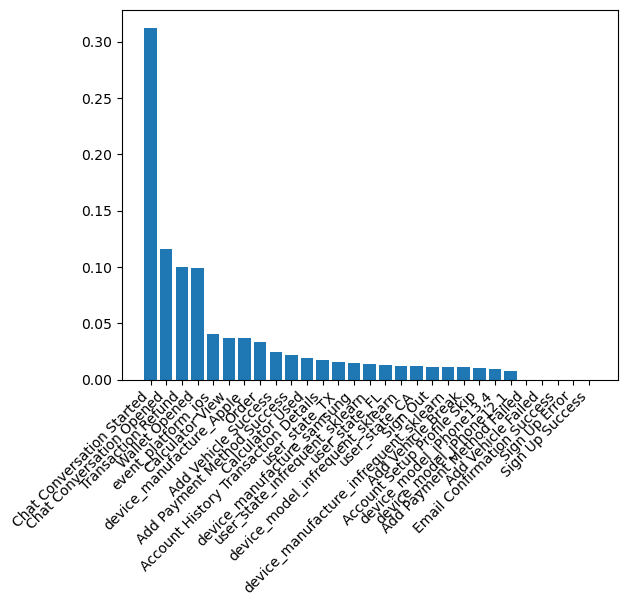

[('Chat Conversation Started', 0.31266087), ('Chat Conversation Opened', 0.11636661), ('Transaction Refund', 0.099656165), ('Wallet Opened', 0.09905557), ('event_platform_ios', 0.040639736), ('Calculator View', 0.03682688), ('device_manufacture_Apple', 0.036730364), ('Order', 0.033431675), ('Add Vehicle Success', 0.024571149), ('Add Payment Method Success', 0.021990215), ('Calculator Used', 0.019352948), ('Account History Transaction Details', 0.017211016), ('user_state_TX', 0.015391958), ('device_manufacture_samsung', 0.014492915), ('user_state_infrequent_sklearn', 0.013658183), ('user_state_FL', 0.012864885), ('device_model_infrequent_sklearn', 0.012290966), ('user_state_CA', 0.012007015), ('Sign Out', 0.011478803), ('device_manufacture_infrequent_sklearn', 0.011184315), ('Add Vehicle Break', 0.010838888), ('Account Setup Profile Skip', 0.0103440685), ('device_model_iPhone13,4', 0.009312094), ('device_model_iPhone12,1', 0.0076426766), ('Add Payment Method Failed', 0.0), ('Add Vehicle

In [10]:
xg = XGBClassifier(objective="reg:logistic",colsample_bytree=0.5,learning_rate=0.1,
max_depth=5, alpha=1, reg_lambda=0, n_estimators=50)

xg.fit(X, y)

# ----------------

fe_imp = sorted(zip(xg.feature_names_in_, xg.feature_importances_), key= lambda x: x[1], reverse=True)

plt.bar([i[0] for i in fe_imp], [i[1] for i in fe_imp])

plt.xticks(rotation=45, ha='right')
plt.show()

print(fe_imp)

##### Let's analyze further. Now we will have new target as the most important feature.

##### Other features are not binary, so we will need to use XGBRegressor.
##### In the exploration process, we have found optimal params for it. Let's check model performs on CV.

In [11]:
X, y = data.drop(['Subscription Premium Cancel', 'Chat Conversation Started'], axis=1), data['Chat Conversation Started']
data_dmatrix = DMatrix(data=X, label=y)
params = {'alpha': 10, 'colsample_bytree': 1, 'lambda': 10, 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'reg:squarederror', 'subsample': 0.9, 'tree_method': 'exact'}

xgb_cv = cv(dtrain=data_dmatrix, nfold=6, metrics='rmse', as_pandas=True, params=params, num_boost_round=50,
            early_stopping_rounds=10, )
xgb_cv.iloc[-1]

train-rmse-mean    1.328869
train-rmse-std     0.069203
test-rmse-mean     1.479799
test-rmse-std      0.605425
Name: 35, dtype: float64

##### Firstly, we are gonna analyze "Chat Conversation Started", as the most important feature.

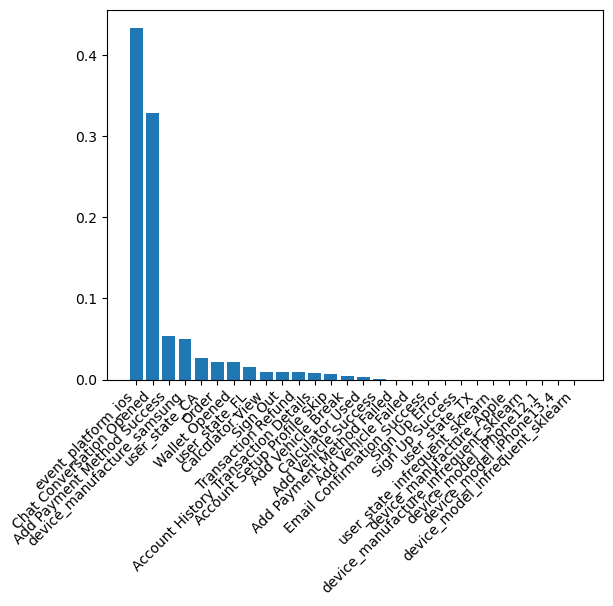

[('event_platform_ios', 0.43412513), ('Chat Conversation Opened', 0.32876703), ('Add Payment Method Success', 0.053093825), ('device_manufacture_samsung', 0.05047304), ('user_state_CA', 0.026520891), ('Order', 0.021094043), ('Wallet Opened', 0.021054951), ('user_state_FL', 0.015142391), ('Calculator View', 0.009491836), ('Sign Out', 0.009204468), ('Transaction Refund', 0.009004461), ('Account History Transaction Details', 0.008423712), ('Account Setup Profile Skip', 0.00625555), ('Add Vehicle Break', 0.003970387), ('Calculator Used', 0.0026857553), ('Add Vehicle Success', 0.0006925948), ('Add Payment Method Failed', 0.0), ('Add Vehicle Failed', 0.0), ('Email Confirmation Success', 0.0), ('Sign Up Error', 0.0), ('Sign Up Success', 0.0), ('user_state_TX', 0.0), ('user_state_infrequent_sklearn', 0.0), ('device_manufacture_Apple', 0.0), ('device_manufacture_infrequent_sklearn', 0.0), ('device_model_iPhone12,1', 0.0), ('device_model_iPhone13,4', 0.0), ('device_model_infrequent_sklearn', 0.0

In [12]:
cols_to_drop = ['Subscription Premium Cancel']
target = 'Chat Conversation Started'
X, y = data.drop(cols_to_drop + [target], axis=1), data[target]

xg = XGBRegressor(alpha=10, reg_lambda=10, learning_rate=0.1,
                  max_depth=3, n_estimators=50, objective='reg:squarederror')

xg.fit(X, y)

# --------------

fe_imp = sorted(zip(xg.feature_names_in_, xg.feature_importances_), key= lambda x: x[1], reverse=True)

plt.bar([i[0] for i in fe_imp], [i[1] for i in fe_imp])

plt.xticks(rotation=45, ha='right')
plt.show()

print(fe_imp)

##### Now "Chat Conversation Opened" - we are deep into this ...

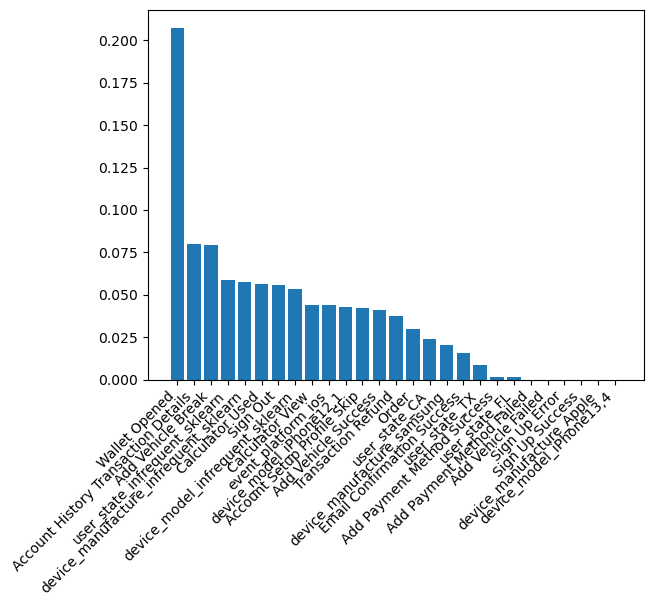

[('Wallet Opened', 0.20752406), ('Account History Transaction Details', 0.07961974), ('Add Vehicle Break', 0.07950882), ('user_state_infrequent_sklearn', 0.05873084), ('device_manufacture_infrequent_sklearn', 0.0572673), ('Calculator Used', 0.056088522), ('Sign Out', 0.055895302), ('device_model_infrequent_sklearn', 0.05341197), ('Calculator View', 0.04422275), ('event_platform_ios', 0.044102676), ('device_model_iPhone12,1', 0.042463873), ('Account Setup Profile Skip', 0.041971494), ('Add Vehicle Success', 0.040866613), ('Transaction Refund', 0.037243795), ('Order', 0.0295335), ('user_state_CA', 0.024166485), ('device_manufacture_samsung', 0.020359969), ('Email Confirmation Success', 0.0155734215), ('user_state_TX', 0.008320085), ('Add Payment Method Success', 0.0017410503), ('user_state_FL', 0.0013877469), ('Add Payment Method Failed', 0.0), ('Add Vehicle Failed', 0.0), ('Sign Up Error', 0.0), ('Sign Up Success', 0.0), ('device_manufacture_Apple', 0.0), ('device_model_iPhone13,4', 0.0

In [13]:
cols_to_drop = ['Subscription Premium Cancel', 'Chat Conversation Started']
target = 'Chat Conversation Opened'
X, y = data.drop(cols_to_drop + [target], axis=1), data[target]

xg = XGBRegressor(alpha=10, reg_lambda=10, learning_rate=0.1,
                  max_depth=3, n_estimators=50, objective='reg:squarederror')

xg.fit(X, y)

# --------------

fe_imp = sorted(zip(xg.feature_names_in_, xg.feature_importances_), key= lambda x: x[1], reverse=True)

plt.bar([i[0] for i in fe_imp], [i[1] for i in fe_imp])

plt.xticks(rotation=45, ha='right')
plt.show()

print(fe_imp)

##### At last, let's check "Transaction Refund", it could give us some interesting information.

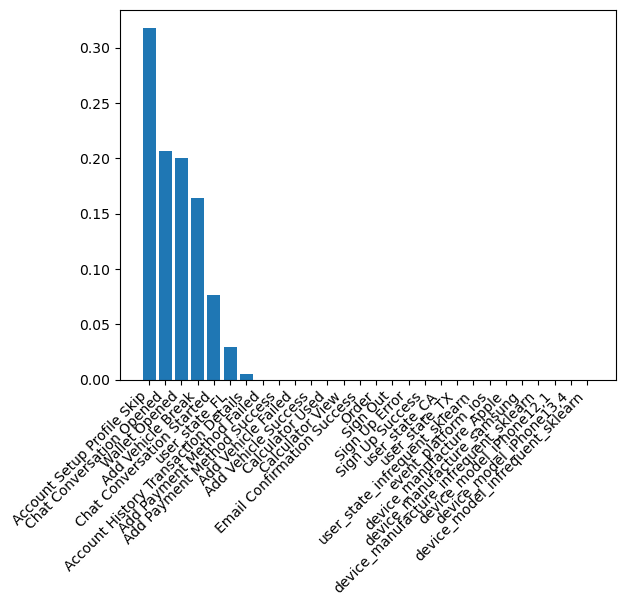

[('Account Setup Profile Skip', 0.31826916), ('Chat Conversation Opened', 0.20618148), ('Wallet Opened', 0.19996445), ('Add Vehicle Break', 0.16449723), ('Chat Conversation Started', 0.07615642), ('user_state_FL', 0.029644031), ('Account History Transaction Details', 0.0052872743), ('Add Payment Method Failed', 0.0), ('Add Payment Method Success', 0.0), ('Add Vehicle Failed', 0.0), ('Add Vehicle Success', 0.0), ('Calculator Used', 0.0), ('Calculator View', 0.0), ('Email Confirmation Success', 0.0), ('Order', 0.0), ('Sign Out', 0.0), ('Sign Up Error', 0.0), ('Sign Up Success', 0.0), ('user_state_CA', 0.0), ('user_state_TX', 0.0), ('user_state_infrequent_sklearn', 0.0), ('event_platform_ios', 0.0), ('device_manufacture_Apple', 0.0), ('device_manufacture_samsung', 0.0), ('device_manufacture_infrequent_sklearn', 0.0), ('device_model_iPhone12,1', 0.0), ('device_model_iPhone13,4', 0.0), ('device_model_infrequent_sklearn', 0.0)]


In [14]:
cols_to_drop = ['Subscription Premium Cancel']
target = 'Transaction Refund'
X, y = data.drop(cols_to_drop + [target], axis=1), data[target]

xg = XGBRegressor(alpha=10, reg_lambda=10, learning_rate=0.1,
                  max_depth=3, n_estimators=50, objective='reg:squarederror')

xg.fit(X, y)

# ----------------

fe_imp = sorted(zip(xg.feature_names_in_, xg.feature_importances_), key= lambda x: x[1], reverse=True)

plt.bar([i[0] for i in fe_imp], [i[1] for i in fe_imp])

plt.xticks(rotation=45, ha='right')
plt.show()

print(fe_imp)

## Results analysis

### Events:

As we can see on the charts above, the most significant events that directly lead to unsubscription are:
- _Chat Conversation Started_
- _Chat Conversation Opened_
- _Transaction Refund_
- _Wallet Opened_

And also events that indirectly influence to _Subscription Premium Cancel_ event (they affect the events mentioned above):
- _Account History Transaction Details_
- _Account Setup Profile Skip_
- _Add Vehicle Break_
- _Calculator Used_

### User properties:

- Two main user properties are `device_manufacture` and `event_platform`.
- Android users more often cancel subsctiption.
- Androids users have 25% more _Transaction Refund_ events that can lead to unsubscription than iOS users. In other words, Android users have more problems with application.
- On average, Android users initiate 4.1 times more _Сhat Сonversations_ than iOS users, supporting the hypothesis above.